Step 1: Train/Test Split

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split

# data_2024 = np.load("../preprocessing/2024_6less.npz")
# data_2023 = np.load("../preprocessing/2023_6less.npz")
# X = np.concatenate([data_2023["inputs"], data_2024["inputs"]], axis=0)
# Y = np.concatenate([data_2023["outputs"], data_2024["outputs"]], axis=0)
data = np.load("../preprocessing/2023_6less.npz")
X, Y = data["inputs"], data["outputs"]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42)
print(len(X_train), len(X_test))

54931 6104


Step 2: CNN Architecture (Pytorch)

In [2]:
import torch
import torch.nn as nn
from ChessMoveCNN import ChessMoveCNN # see ChessMoveCNN.py

Step 3: Loss Function and Training Setup

In [3]:
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

train_ds = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(Y_train, dtype=torch.float32))
test_ds  = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(Y_test, dtype=torch.float32))

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=64)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = ChessMoveCNN().to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-3)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

cuda


Step 4: Training Loop

In [4]:
best_loss = float('inf')

train_losses = []
test_losses = []
epochs = 6

for epoch in range(epochs):
    model.train()
    total_train_loss = 0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = loss_fn(preds, yb)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Evaluation
    model.eval()
    total_test_loss = 0

    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = loss_fn(preds, yb)
            total_test_loss += loss.item()

    avg_test_loss = total_test_loss / len(test_loader)
    test_losses.append(avg_test_loss)

    scheduler.step(avg_test_loss)

    if avg_test_loss < best_loss:
        best_loss = avg_test_loss
        torch.save(model.state_dict(), "early_stop.pt")

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f} - Test Loss: {avg_test_loss:.4f}")

Epoch 1/6 - Train Loss: 0.0691 - Test Loss: 0.0323
Epoch 2/6 - Train Loss: 0.0285 - Test Loss: 0.0269
Epoch 3/6 - Train Loss: 0.0255 - Test Loss: 0.0254
Epoch 4/6 - Train Loss: 0.0238 - Test Loss: 0.0245
Epoch 5/6 - Train Loss: 0.0226 - Test Loss: 0.0244
Epoch 6/6 - Train Loss: 0.0214 - Test Loss: 0.0242


In [5]:
model.load_state_dict(torch.load("early_stop.pt"))

<All keys matched successfully>

Step 5: Loss Plotting and Test Case Visualization

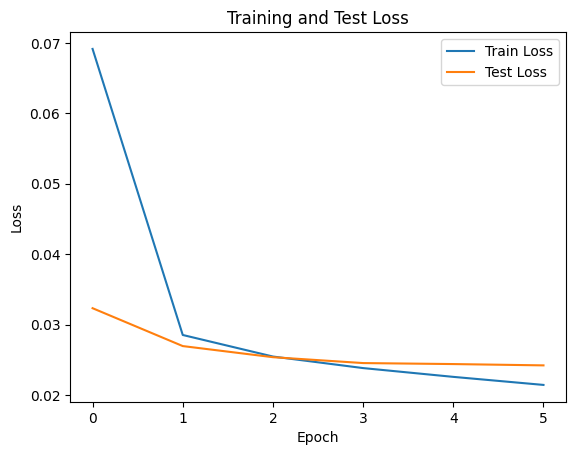

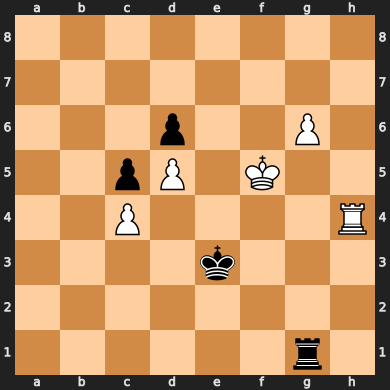

Top 5 predicted moves:
e3d3: 0.3123
g1f1: 0.1132
e3f3: 0.0382
g1g6: 0.0367
e3d2: 0.0345

Ground Truth Move: g1f1


In [6]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Test Loss")
plt.show()

import sys
sys.path.insert(1, "../preprocessing")
import utils

# Pick a test sample
idx = np.random.randint(len(X_test))
x = torch.tensor(X_test[idx:idx+1], dtype=torch.float32).to(device)
y_pred = model(x)[0]  # shape: (2, 8, 8)

board = utils.tensor_to_board(X_test[idx])
display(board)
top5_moves = model.get_top_moves(board, 5)

print("Top 5 predicted moves:")
for move, score in top5_moves:
    print(f"{move.uci()}: {score:.4f}")

y_true = Y_test[idx]  # shape: (2, 8, 8)
# Find the '1' (or highest value) in the start plane and end plane
start_idx = np.argmax(y_true[0].flatten()) 
end_idx   = np.argmax(y_true[1].flatten()) 

# Convert to square names just like the predicted moves
import chess
start_sq = chess.square_name(start_idx)
end_sq   = chess.square_name(end_idx)
true_uci = f"{start_sq}{end_sq}"

print("\nGround Truth Move:", true_uci)

100%|██████████| 6104/6104 [08:23<00:00, 12.13it/s]

Top-1 Accuracy: 0.441
Top-5 Accuracy: 0.888


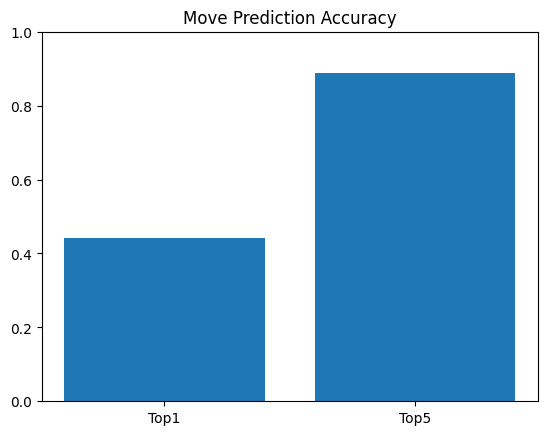

In [7]:
# New cell to compute and plot Top-1 and Top-5 Accuracy
import matplotlib.pyplot as plt
from tqdm import tqdm

top1_correct = 0
top5_correct = 0
num_samples = len(X_test)

for i in tqdm(range(num_samples)):
    # Model prediction
    x = torch.tensor(X_test[i:i+1], dtype=torch.float32).to(device)
    y_pred = model(x)[0]  # shape: (2, 8, 8)

    # Ground-truth move (assuming y_test has shape [N, 2, 8, 8])
    y_true = Y_test[i]
    start_idx = np.argmax(y_true[0].flatten())  # index 0..63
    end_idx   = np.argmax(y_true[1].flatten())  # index 0..63

    # Get predicted top-5 moves
    # (start_str, end_str, uci_str, score)
    board = utils.tensor_to_board(x[0])
    top5_moves = model.get_top_moves(board, 5)

    # Check if Top-1 matches ground truth
    top1_move = top5_moves[0][0]
    if top1_move.from_square == start_idx and top1_move.to_square == end_idx:
        top1_correct += 1

    # Check if ground truth is in Top-5
    for (move, score) in top5_moves:
        if move.from_square == start_idx and move.to_square == end_idx:
            top5_correct += 1
            break

top1_accuracy = top1_correct / num_samples
top5_accuracy = top5_correct / num_samples

print(f"Top-1 Accuracy: {top1_accuracy:.3f}")
print(f"Top-5 Accuracy: {top5_accuracy:.3f}")

# Plot as a simple bar chart
plt.bar(["Top1", "Top5"], [top1_accuracy, top5_accuracy])
plt.ylim(0, 1)
plt.title("Move Prediction Accuracy")
plt.show()

torch.save()